In [1]:
import torch
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Custom transforms for radio signals
class TimeReversal:
    """
    Reverse the time axis of the input tensor.

    Example:
        >>> transform = TimeReversal(dim=1)
        >>> x = torch.arange(1, 51).reshape(10, 5)
        >>> x
        tensor([[ 1,  2,  3,  4,  5],
                [ 6,  7,  8,  9, 10],
                [11, 12, 13, 14, 15],
                [16, 17, 18, 19, 20],
                [21, 22, 23, 24, 25],
                [26, 27, 28, 29, 30],
                [31, 32, 33, 34, 35],
                [36, 37, 38, 39, 40],
                [41, 42, 43, 44, 45],
                [46, 47, 48, 49, 50]])
        >>> transform(x)
        tensor([[ 5,  4,  3,  2,  1],
                [10,  9,  8,  7,  6],
                [15, 14, 13, 12, 11],
                [20, 19, 18, 17, 16],
                [25, 24, 23, 22, 21],
                [30, 29, 28, 27, 26],
                [35, 34, 33, 32, 31],
                [40, 39, 38, 37, 36],
                [45, 44, 43, 42, 41],
                [50, 49, 48, 47, 46]]
    """

    def __init__(self, dim):
        self.dim = dim

    def __call__(self, x):
        return torch.flip(x, [self.dim])


class TimeCrop:
    """
    Crop the time axis of the input tensor.

    Example:
        >>> transform = TimeCrop(crop_size=5, dim=0)
        >>> x = torch.arange(1, 51).reshape(10, 5)
        >>> x
        tensor([[ 1,  2,  3,  4,  5],
                [ 6,  7,  8,  9, 10],
                [11, 12, 13, 14, 15],
                [16, 17, 18, 19, 20],
                [21, 22, 23, 24, 25],
                [26, 27, 28, 29, 30],
                [31, 32, 33, 34, 35],
                [36, 37, 38, 39, 40],
                [41, 42, 43, 44, 45],
                [46, 47, 48, 49, 50]])
        >>> transform(x)
        tensor([[ 1,  2,  3,  4,  5],
                [ 6,  7,  8,  9, 10],
                [11, 12, 13, 14, 15],
                [16, 17, 18, 19, 20],
                [21, 22, 23, 24, 25]])
    """

    def __init__(self, crop_size, dim):
        self.crop_size = crop_size
        self.dim = dim

    def __call__(self, x: torch.Tensor):
        rand_start_idx = torch.randint(
            0, x.size(self.dim) - self.crop_size + 1, (1,)).item()
        slices = [slice(None)] * x.ndim
        slices[self.dim] = slice(
            rand_start_idx, rand_start_idx + self.crop_size)
        return x[slices]


class RandomTimeShift:
    """
    Shift the time axis of the input tensor by a random amount.

    Example:
        >>> x = torch.arange(1, 51).reshape(10, 5)
        >>> transform = RandomTimeShift(dim=1, max_shift=5)
        >>> x
        tensor([[ 1,  2,  3,  4,  5],
                [ 6,  7,  8,  9, 10],
                [11, 12, 13, 14, 15],
                [16, 17, 18, 19, 20],
                [21, 22, 23, 24, 25],
                [26, 27, 28, 29, 30],
                [31, 32, 33, 34, 35],
                [36, 37, 38, 39, 40],
                [41, 42, 43, 44, 45],
                [46, 47, 48, 49, 50]])
        >>> transform(x)
        tensor([[ 0,  0,  1,  2,  3,  4,  5],
                [ 0,  0,  6,  7,  8,  9, 10],
                [ 0,  0, 11, 12, 13, 14, 15],
                [ 0,  0, 16, 17, 18, 19, 20],
                [ 0,  0, 21, 22, 23, 24, 25],
                [ 0,  0, 26, 27, 28, 29, 30],
                [ 0,  0, 31, 32, 33, 34, 35],
                [ 0,  0, 36, 37, 38, 39, 40],
                [ 0,  0, 41, 42, 43, 44, 45],
                [ 0,  0, 46, 47, 48, 49, 50]])
    """

    def __init__(self, max_shift, dim=0):
        self.max_shift = max_shift
        self.dim = dim

    def __call__(self, x):
        self.max_shift = min(self.max_shift, x.size(self.dim) - 1)
        shift = max(torch.randint(0, self.max_shift, (1,)).item(), 1)
        zeros = torch.zeros_like(x)

        # shift can only mean shift to the right
        return torch.cat((zeros.narrow(self.dim, 0, shift), x), dim=self.dim)


class RandomAmplitudeScale:
    """
    Scale the amplitude of the input tensor by a random factor.

    Example:
        >>> transform = RandomAmplitudeScale(scale_factor=0.1)
        >>> x = torch.arange(1, 51).reshape(10, 5)
        >>> transform(x)
    """

    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, x):
        return x * (1 + torch.rand(1) * self.scale_factor)


class RandomResample:
    """
    Resample the input tensor by a random factor.

    :param max_rate: Maximum resampling rate (up/down sampling). E.g. 0.1 means
        the resampling rate will be randomly chosen between 0.9 and 1.1.
    :type max_rate: float
    :param dim: Dimension along which to resample.
    :type dim: int (default = 0)

    Example:
        >>> x = torch.linspace(1, 51, 50)
        >>> y = torch.exp(1j * -x**2/6.0)
        >>> y = torch.stack((y.real, y.imag), dim=-1)
        >>> transform = RandomResample(max_rate=0.1)
        >>> y_transformed = transform(y)
        >>> y.shape, y_transformed.shape
        (torch.Size([50, 2]), torch.Size([74, 2]))
    """

    def __init__(self, max_rate, dim=0):
        self.max_rate = max_rate
        self.dim = dim

    def __call__(self, x: torch.Tensor):
        down = x.size(self.dim)
        up = int(down * (1 + torch.rand(1).item() * self.max_rate))
        # upsample -> filter -> downsample
        poly_filt = signal.resample_poly(x, up, down, axis=self.dim,
                                         window=('kaiser', 7.0))
        return torch.from_numpy(poly_filt)


class RandomAddNoise:
    """
    Add noise to the input tensor.

    :param mean: Mean of the noise.
    :type mean: float (default = 0.0)
    :param std: Standard deviation of the noise.
    :type std: float (default = 1.0)

    Example:
        >>> x = torch.arange(1, 51).reshape(10, 5)
        >>> transform = RandomAddNoise(noise_level=0.1)
        >>> transform(x)
    """

    def __init__(self, mean=0.0, std=1.0):
        self.mean, self.std = map(torch.tensor, (mean, std))

    def __call__(self, x):
        noise = torch.normal(mean=self.mean, std=self.std, size=x.size())
        return x + noise


class RandomFrequencyShift:
    """
    Shift the frequency of the input tensor by a random factor.

    :param fs: Sampling frequency of the input tensor.
    :type fs: float (default = 1)
    :param dim: Dimension along which to shift the frequency.
    :type dim: int (default = 0)

    :rtype: torch.Tensor

    :note: The transformation expects either BxCxK or BxK input shape.

    Example:
        >>> x = torch.linspace(1, 51, 50)
        >>> y = torch.exp(1j * -x**2/6.0)
        >>> y = torch.stack((y.real, y.imag), dim=0)
        >>> transform = RandomFrequencyShift(fs=1, dim=0)
        >>> transform(y)
    """

    def __init__(self, fs=1, dim=-1):
        self.fs = fs
        self.dim = dim

    def __call__(self, x: torch.Tensor):
        # maximum shift is half the sampling frequency
        max_shift = self.fs / 2
        shift = max_shift * (2 * torch.rand(1).item() - 1)
        t = torch.arange(x.size(self.dim))
        f = torch.exp(1j * 2 * np.pi * shift * t)
        # apply the frequency shift to the channel dimension
        # e.g if dim=0, shift the rows, each row is mapped to the real and imaginary part
        f = torch.stack((f.real, f.imag))
        return x * f


class RandomPhaseShift:
    """
    Shift the phase of the input tensor by a random factor.

    :param max_shift: Maximum phase shift in radians.
    :type max_shift: float (default = pi)
    :param dim: Dimension along which to shift the phase.
    :type dim: int (default = 0)
    :rtype: torch.Tensor

    Example:
        >>> x = torch.linspace(1, 51, 50)
        >>> y = torch.exp(1j * -x**2/6.0)
        >>> y = torch.stack((y.real, y.imag), dim=0)
        >>> transform = RandomPhaseShift(max_shift=np.pi)
        >>> transform(y)
    """

    def __init__(self, max_shift=np.pi, dim=0):
        self.max_shift = max_shift
        self.dim = dim

    def __call__(self, x: torch.Tensor):
        shift = self.max_shift * (2 * torch.rand(1).item() - 1)
        phase = torch.exp(torch.tensor(1j) * shift)
        # apply the phase shift to the channel dimension
        # e.g if dim=0, shift the rows, each row is mapped to the real and imaginary part
        phase = torch.stack((phase.unsqueeze(0).real, phase.unsqueeze(0).imag))
        dim = [1] * x.ndim
        dim[self.dim] = 2
        return x * phase.view(*dim)


class RandomZeroMasking:
    """
    Mask a random number of elements in the input tensor with zeros.

    :param max_mask_size: Maximum number of elements to mask.
    :type max_mask_size: int (default = 5)
    :param dim: Dimension along which to mask the elements.
    :type dim: int (default = 0)
    :rtype: torch.Tensor

    Example:
        >>> x = torch.linspace(1, 51, 50)
        >>> y = torch.exp(1j * -x**2/6.0)
        >>> y = torch.stack((y.real, y.imag))
        >>> transform = RandomZeroMasking(max_mask_size=25)
        >>> transform(y)
    """

    def __init__(self, max_mask_size=5, dim=0):
        self.max_mask_size = max_mask_size
        self.dim = dim

    def __call__(self, x: torch.Tensor):
        mask_size = max(torch.randint(
            0, self.max_mask_size + 1, (1,)).item(), 2)
        mask = torch.ones_like(x)
        mask_idx = [slice(None)] * x.ndim
        rand_start_idxs = torch.randint(
            0, x.size(self.dim), (max(min((x.size(self.dim) - mask_size) // 5, 5), 1),))
        mask_idx[self.dim] = torch.flatten(rand_start_idxs.unsqueeze(1)
                                           + torch.arange(mask_size).unsqueeze(0))
        mask_idx[self.dim] = mask_idx[self.dim].clamp(0, x.size(self.dim) - 1)
        mask[mask_idx] = 0
        return x * mask


class RandomDCShift:
    """
    Shift the DC component of the input tensor by a random factor.

    :param max_shift: Maximum shift of the DC component.
    :type max_shift: float (default = 1)
    :param dim: Dimension along which to shift the DC component.
    :type dim: int (default = 0)
    :rtype: torch.Tensor

    Example:
        >>> x = torch.arange(1, 51).reshape(10, 5)
        >>> transform = RandomDCShift(max_shift=5)
        >>> transform(x)
    """

    def __init__(self, max_shift=1, dim=0):
        self.max_shift = max_shift
        self.dim = dim

    def __call__(self, x: torch.Tensor):
        shift = self.max_shift * (2 * torch.rand(1).item() - 1)
        return x - x.mean(dim=self.dim) * shift

In [3]:
x = torch.linspace(1, 51, 50)
y = torch.exp(1j * -x**2/6.0)
y = torch.stack((y.real, y.imag), dim=0)

In [4]:
transformed = RandomAddNoise(std=0.001)(y)
transformed = RandomFrequencyShift(dim=-1)(transformed)
transformed = RandomPhaseShift(dim=0)(transformed)
transformed = RandomZeroMasking(max_mask_size=5, dim=-1)(transformed)
resampled = RandomResample(max_rate=8, dim=-1)(transformed)
transformed = RandomDCShift(max_shift=3, dim=0)(resampled)
transformed = RandomAmplitudeScale(scale_factor=0.1)(transformed)
transformed = TimeReversal(dim=-1)(transformed)
transformed = RandomTimeShift(max_shift=10, dim=-1)(transformed)

time_cropped = TimeCrop(crop_size=50, dim=-1)(transformed)

In [5]:
diff = transformed.shape[1] - resampled.shape[1]
xnew = torch.concatenate((torch.arange(1, diff + 1), torch.linspace(
    diff + 1, diff + 51, resampled.shape[1])))

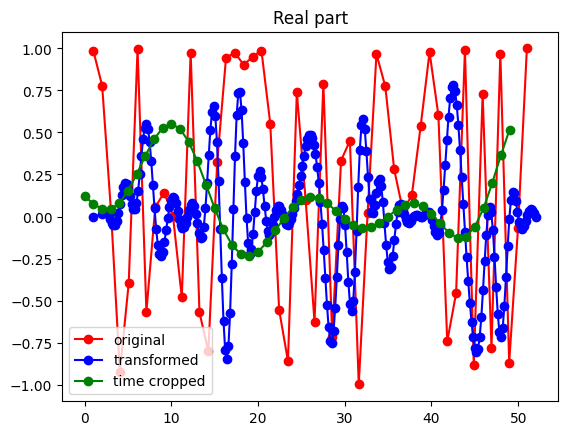

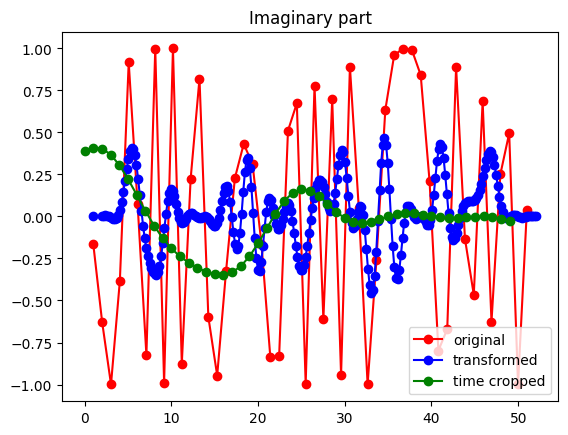

In [6]:
for i in range(y.shape[0]):
    plt.plot(x, y[i], 'ro-', label='original')
    plt.plot(xnew, transformed[i], 'bo-', label='transformed')
    plt.plot(time_cropped[i], 'go-', label='time cropped')
    plt.legend()
    plt.title("Real part" if i == 0 else "Imaginary part")
    plt.show()